This notebook is a scratch-pad-turned-reference. Expect to see some mistakes left in for discussion, and probably some misinformed choices.  
Jes Parker, 2/7/18  
jmparker@berkeley.edu

# ASDF from scratch
The tutorial for `pyasdf` at http://seismicdata.github.io/pyasdf/tutorial.html is a great starting point for general seismic analysis, i.e. assuming you have QuakeML and StationXML files ready to be assimilated into ASDF. My lab EQ data is all raw and messy, so I'll need to start out by creating these sub-structures.

## StationXML for the lab
I'll follow this ObsPy tutorial on __[creating a StationXML file from scratch](https://docs.obspy.org/tutorial/code_snippets/stationxml_file_from_scratch.html)__.

The lab sensor network is named the Glaser Lab Nano-Network (GLNN or GL) here, for local purposes only. This will fit into a file hierarchy of **Inventory > Network > Station > Channel**.

In [1]:
import obspy
from obspy.core.inventory import Inventory, Network, Station, Channel, Site
from obspy.clients.nrl import NRL

Each of the hierarchy levels is an object that needs to be created. For now, I'm following the tutorial exactly rather than starting to incorporate real info about the GLNN.

In [2]:
inv = Inventory(
    # We'll add networks later.
    networks=[],
    # The source should be the id of whoever creates the file.
    source="ObsPy-Tutorial")

net = Network(
    # This is the network code according to the SEED standard.
    code="XX",
    # A list of stations. We'll add one later.
    stations=[],
    description="A test of stations.",
    # Start and end dates are optional.
    start_date=obspy.UTCDateTime(2016, 1, 2))

sta = Station(
    # This is the station code according to the SEED standard.
    code="ABC",
    latitude=1.0,
    longitude=2.0,
    elevation=345.0,
    creation_date=obspy.UTCDateTime(2016, 1, 2),
    site=Site(name="First station"))

cha = Channel(
    # This is the channel code according to the SEED standard.
    code="HHZ",
    # This is the location code according to the SEED standard.
    location_code="",
    # Note that these coordinates can differ from the station coordinates.
    latitude=1.0,
    longitude=2.0,
    elevation=345.0,
    depth=10.0,
    azimuth=0.0,
    dip=-90.0,
    sample_rate=200)

Next the tutorial pulls a station response file from the Nominal Response Library. This is a repository of instrument responses for commercial seismometers, but it's unlikely to be useful for lab sensors. I'll include it here for the sake of continuing to follow the tutorial.

In [3]:
# By default this accesses the NRL online. Offline copies of the NRL can
# also be used instead
nrl = NRL()
# The contents of the NRL can be explored interactively in a Python prompt,
# see API documentation of NRL submodule:
# http://docs.obspy.org/packages/obspy.clients.nrl.html
# Here we assume that the end point of data logger and sensor are already known:
response = nrl.get_response( # doctest: +SKIP
    sensor_keys=['Streckeisen', 'STS-1', '360 seconds'],
    datalogger_keys=['REF TEK', 'RT 130 & 130-SMA', '1', '200'])

Combine the objects we've created.

In [4]:
cha.response = response
sta.channels.append(cha)
net.stations.append(sta)
inv.networks.append(net)

Finally write it to a StationXML file. We also force a validation against the StationXML schema to ensure it produces a valid StationXML file. There's a note that "it's also possible to serialize to any of the other inventory output formats ObsPy supports." I'm not sure what that means.

In [5]:
inv.write("test_station.xml", format="stationxml", validate=True)

In [6]:
!ls ./

Learning_ASDF.ipynb  test_station.xml


## QuakeML from scratch
Next I need to figure out how to make a QuakeML file for a lab event. There is no tutorial I could find so we'll dig through the documentation. There's a quakeml package with a write function, `obspy.core.quakeml.writeQuakeML`, but it's doc has a big warning that it should only be used through the write function of an ObsPy `Catalog` object.

The __[Catalog class](http://docs.obspy.org/packages/autogen/obspy.core.event.catalog.Catalog.html#obspy.core.event.catalog.Catalog)__ is just a container for __[Event objects](http://docs.obspy.org/packages/autogen/obspy.core.event.event.Event.html#obspy.core.event.event.Event)__. `Event` objects start to have actual info in them, although a bunch of it also goes into sub-classes like `Pick`, `Origin`, `Magnitude`, etc. I'll go ahead and try to create a fully populated `Event` with dummy info.

In [1]:
import obspy
import obspy.core.event as ev

There seems to be a lot of value in properly used __[ResourceIdentifier](https://docs.obspy.org/packages/autogen/obspy.core.event.base.ResourceIdentifier.html#obspy.core.event.base.ResourceIdentifier)__s. It seems like most of the referencing will be auto-generated. I'll try starting with a `ResourceIdentifier` for an event and filling in from there.

In [2]:
event = ev.Event()
event.resource_id = ev.ResourceIdentifier(prefix='event', referred_object=event)
print(event, event.resource_id)

Event:	

 event/f55e54b9-d5aa-4b23-9116-5de95a7f8657


There's no laboraty event `EventType` so I'll use "other event" with "known" certainty.

In [3]:
event.event_type = ev.header.EventType(enum='other event')
event.event_type_certainty = ev.header.EventTypeCertainty(enum='known')
event.event_type = 'other ev'

ValueError: Setting attribute "event_type" failed. Value "other ev" could not be converted to type "Enum(["not existing", "not reported", "earthquake", ..., "rockslide", "meteorite", "volcanic eruption"])"

I noticed that the value actually stored for `event.event_type` was just the string 'other event', so I was curious if I could just assign a string instead of an `EventType` object. The error from trying to set 'other ev' shows that the `Event.event_type` parameter automatically invokes the `EventType` class and checks that the assigned string is in the enumerated list. A simple string assignment works with allowed value and produces exactly the same stored value as the object assignment I initially used.

The next parameter (alphabetically) is `Event.creation_info`. A `CreationInfo` object can contain an `agency_id`, an `agency_uri`, an `author`, an `author_uri`, a `creation_time`, and a `version`. The two uri fields both take (or create if called with just a string?) `ResourceIdentifier` objects. I'll fill in some dummy info for completeness of this exercise.

In [4]:
event.creation_info = ev.base.CreationInfo(author='JP', creation_time=obspy.core.UTCDateTime.utcnow())
print(event.creation_info)

CreationInfo(author='JP', creation_time=UTCDateTime(2018, 2, 7, 19, 11, 49, 520680))


Next is `Event.event_descriptions`, which can contain a list of `EventDescription` objects. Each of these contains a piece of descriptive text and an optional `EventDescriptionType` such as "earthquake name". The types are an extra bit of standardized metadata that could make filtering for events easier. I've tried adding a description but there is no automatic processing getting triggered. The assignment seems to be verbatim and the `event_descriptions` key doesn't show up as part of the `Event` dictionary if I e.g. `print(event.keys())`. However, `print(event)` does include "event_descriptions: 1 Elements". Something to come back to.

In [5]:
event.event_descriptions = [ev.event.EventDescription(text='a fake example event')]
print(event.event_descriptions)

[EventDescription(text='a fake example event')]


`Event.comments` is another list field, although `Comment` objects can have a `ResourceIdentifier` and `CreationInfo`. 

The remaining parameters for an `Event` are `picks`, `amplitudes`, `focal_mechanisms`, `origins`, `magnitudes`, and `station_magnitudes`. All of these parameters have their own classes and are able to contain quite a lot of inter-related information. Filling these in will make much more sense with sample data. For now, I have a very empty `Event` that should be enough to write a very empty QuakeML file to use in my ASDF trial.

Recall above I found that `writeQuakeML` directed me to use the `Catalog.write` method instead. Here I put my dummy event into a dummy catalog and write to test_cat.xml, but in doing so I learned that `Event.write` would also have worked on its own.

In [7]:
catalog = ev.Catalog(creation_info=ev.base.CreationInfo(author='JP', creation_time=obspy.core.UTCDateTime.utcnow()))
catalog.resource_id = ev.ResourceIdentifier(prefix='catalog', referred_object=catalog)
catalog.append(event)
catalog.write("test_cat.xml", format="QUAKEML")

## Creating the ASDF file
Now we have some dummy files we can use for an example of creating a new ASDF file.

In [8]:
import pyasdf
ds = pyasdf.ASDFDataSet("test_asdf.h5", compression="gzip-3")
print(ds)

ASDF file [format version: 1.0.1]: 'test_asdf.h5' (96.0 bytes)
	Contains 0 event(s)
	Contains waveform data from 0 station(s).


/home/jes-lab/anaconda3/envs/obspy/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We can add the event data from the QuakeML file. There's a salient note here in the ``pyasdf`` tutorial: "Be aware that all operations will directly write to the file without an explicit _save/write_ step. This enables ``pyasdf`` to deal with arbitrarily big data sets."

In [9]:
ds.add_quakeml("test_cat.xml")
print(ds)

ASDF file [format version: 1.0.1]: 'test_asdf.h5' (6.0 KB)
	Contains 1 event(s)
	Contains waveform data from 0 station(s).


In [11]:
print(event)
print(ds.events[0])

Event:	

	          resource_id: ResourceIdentifier(id="event/f55e54b9-d5aa-4b23-9116-5de95a7f8657")
	           event_type: 'other event'
	 event_type_certainty: 'known'
	        creation_info: CreationInfo(author='JP', creation_time=UTCDateTime(2018, 2, 7, 19, 11, 49, 520680))
	                 ---------
	   event_descriptions: 1 Elements
Event:	

	          resource_id: ResourceIdentifier(id="smi:local/event/f55e54b9-d5aa-4b23-9116-5de95a7f8657")
	           event_type: 'other event'
	 event_type_certainty: 'known'
	        creation_info: CreationInfo(author='JP', creation_time=UTCDateTime(2018, 2, 7, 19, 11, 49, 520680))
	                 ---------
	   event_descriptions: 1 Elements


The event is now accessible through the ASDF dataset. In writing the QuakeML file, the resource_id was updated to a full URI in line with the QuakeML standard. Otherwise the `Event` object is unchanged.

Let's add the staion info next, then figure out how to deal with non-standard waveform sources. I'll leave the tutorial's for loop that prints the progress when uploading many files.

In [14]:
import glob
files = glob.glob("*station.xml")
for _i, filename in enumerate(files):
    print("Adding file %i of %i ..." % (_i + 1, len(files)))
    ds.add_stationxml(filename)
print(ds)

Adding file 1 of 1 ...
ASDF file [format version: 1.0.1]: 'test_asdf.h5' (12.4 KB)
	Contains 1 event(s)
	Contains waveform data from 1 station(s).


Now I see why the tutorial adds waveforms before station info - the print statement assumes any station in the file must have waveform data. Let's see what some more specific prints produce. Remember that station info is split up into individual stations and grouped with waveforms.

In [22]:
print(ds.get_all_coordinates())
print(ds.waveforms.list())
ds.waveforms.XX_ABC.StationXML

{'XX.ABC': {'latitude': 1.0, 'longitude': 2.0, 'elevation_in_m': 345.0}}
['XX.ABC']


Inventory created at 2018-02-06T21:46:15.414255Z
	Created by: ObsPy 1.1.0
		    https://www.obspy.org
	Sending institution: ObsPy-Tutorial
	Contains:
		Networks (1):
			XX
		Stations (1):
			XX.ABC (First station)
		Channels (1):
			XX.ABC..HHZ

### Adding an arbitrary waveform
Waveforms are added to the ASDF dataset through ``ds.add_waveforms``. The module expects standard seismic data formats such as SAC and miniSEED, but it also accepts ObsPy __[Stream](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html#obspy.core.stream.Stream)__ objects. ``Stream``s are lists of __[Trace](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.html#obspy.core.trace.Trace)__ objects, which contain data of a continuous series as an ndarray and header info. Let's make a random ``Trace`` and see what we can do with it.

In [ ]:
from numpy.random import randn
from obspy import Stream, Trace

wf1 = randn(1000)
trace = Trace(data=wf1)

In [25]:
print(trace.stats)

         network: 
         station: 
        location: 
         channel: 
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:16:39.000000Z
   sampling_rate: 1.0
           delta: 1.0
            npts: 1000
           calib: 1.0


Making a trace with nothing but a data array fills in some default values. What will ASDF do with a trace with no station info?

In [34]:
ds.add_waveforms(trace, "raw_record") # throws a warning and doesn't add if already present
print(ds.waveforms.list())

/home/jes-lab/anaconda3/envs/obspy/lib/python3.6/site-packages/pyasdf/asdf_data_set.py:51: ASDFWarning: Data './...__1970-01-01T00:00:00__1970-01-01T00:16:39__raw_record' already exists in file. Will not be added!
  closure_warn(self, *args, **kwargs)


['...__1970-01-01T00:00:00__1970-01-01T00:16:39__raw_record', 'XX.ABC']


The auto-generated network and station name starts with three dots, which makes the waveform and associated info inaccessible through the `ds.waveform.NET_STAT` object. The `add_waveforms` method has no mechanism for forcing station info, so it has to come through the `Stream` or `Trace`. I'll try simply associating to the dummy station already in the dataset. A `Trace` has station info stored in its header parameter which takes either a `dict` or a helper `Stats` object. The `Trace.id` variable also replaces those three dots without filling in any real station info.

In [67]:
from obspy.core import Stats
stats = Stats()
stats.network = 'XX'
stats.station = 'ABC'
stats.channel = 'HHZ'
trace2 = Trace(data=wf1, header=stats) # new trace with proper header
trace.id = 'XX.ABC..HHZ' # put the station and channel info on with no other info
print(trace, trace2, sep='\n')
print(trace.stats, trace2.stats)

XX.ABC..HHZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:16:39.000000Z | 1.0 Hz, 1000 samples
XX.ABC..HHZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.000000Z | 1.0 Hz, 0 samples
         network: XX
         station: ABC
        location: 
         channel: HHZ
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:16:39.000000Z
   sampling_rate: 1.0
           delta: 1.0
            npts: 1000
           calib: 1.0          network: XX
         station: ABC
        location: 
         channel: HHZ
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:00:00.000000Z
   sampling_rate: 1.0
           delta: 1.0
            npts: 0
           calib: 1.0


Now we see that the lazier `trace.id` method was actually a more foolproof choice. When I made a `Stats` object, I didn't realize that the default `npts` value of 0 would override the trace data. I'll change the channel on `trace2` and we can see what ASDF does with an empty waveform.

In [70]:
trace2.id = 'XX.ABC..HHR'
ds.add_waveforms(trace,"raw_record")
ds.add_waveforms(trace2,"empty_record")

In [72]:
ds.waveforms.XX_ABC.list()

['StationXML',
 'XX.ABC..HHR__1970-01-01T00:00:00__1970-01-01T00:00:00__empty_record',
 'XX.ABC..HHZ__1970-01-01T00:00:00__1970-01-01T00:16:39__raw_record']

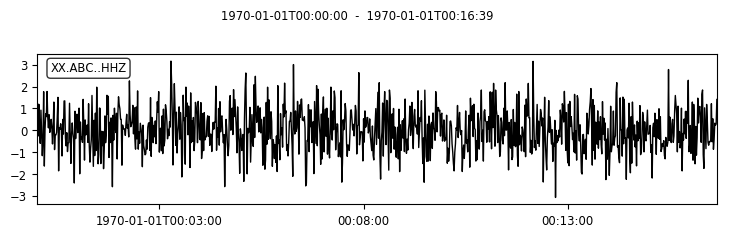

In [80]:
import matplotlib.pyplot as plt
ds.waveforms.XX_ABC.raw_record.plot()

In [89]:
ds.waveforms.XX_ABC.empty_record.append([randn(4)])
ds.waveforms.XX_ABC.empty_record.plot()

TypeError: Append only supports a single Trace object as an argument.

I can only append a trace to a trace within an ASDF. That makes sense - it probably also checks the time stamps and sampling frequency to make sure the data is continuous.

I've successfully added some non-standard seismic data as a waveform in the dataset, properly associated with a station and channel. Last for this section, let's see if I can associate an event to the waveform retroactively.

In [90]:
event = ds.events[0] # clarify to the post-QuakeML formatting event
ds.add_waveforms(trace,"raw_record",event_id=event)

/home/jes-lab/anaconda3/envs/obspy/lib/python3.6/site-packages/pyasdf/asdf_data_set.py:51: ASDFWarning: Data 'XX.ABC/XX.ABC..HHZ__1970-01-01T00:00:00__1970-01-01T00:16:39__raw_record' already exists in file. Will not be added!
  closure_warn(self, *args, **kwargs)


In [95]:
ds.waveforms.XX_ABC.raw_record.event_id = event

In [102]:
ds.waveforms.XX_ABC.raw_record.event_id

AttributeError: 'Stream' object has no attribute 'event_id'

I can't find a method that adds an event_id, or other similar parameters, after the waveform has been added. The `add_waveforms` method also doesn't overwrite an existing trace if called again, it just throws a warning. There seems to be no 'easy' way to add event or other info to a waveform. Probably I would have to pull the trace then re-add it with the event info.

In [106]:
del(trace)
trace = ds.waveforms.XX_ABC.raw_record[0]
del(ds.waveforms.XX_ABC.raw_record)
ds.waveforms.XX_ABC.list()

['StationXML',
 'XX.ABC..HHR__1970-01-01T00:00:00__1970-01-01T00:00:00__empty_record']

In [107]:
ds.add_waveforms(trace,"raw_record",event_id=event)
ds.waveforms.XX_ABC.list()

['StationXML',
 'XX.ABC..HHR__1970-01-01T00:00:00__1970-01-01T00:00:00__empty_record',
 'XX.ABC..HHZ__1970-01-01T00:00:00__1970-01-01T00:16:39__raw_record']

The pyasdf tutorial shows us how to get info about associated events:

In [114]:
cat = ds.events # The events have to be in memory for the reference to work
print(ds.waveforms.XX_ABC.raw_record[0].stats.asdf.event_ids[0].get_referred_object())

Event:	

	          resource_id: ResourceIdentifier(id="event/f55e54b9-d5aa-4b23-9116-5de95a7f8657")
	           event_type: 'other event'
	 event_type_certainty: 'known'
	        creation_info: CreationInfo(author='JP', creation_time=UTCDateTime(2018, 2, 7, 19, 11, 49, 520680))
	                 ---------
	   event_descriptions: 1 Elements


That worked but boy is it messy. I'll have to mess around with this more and get used to the framework.

### Auxiliary Data
The last (creation) section of the `pyasdf` tutorial is a brief intro to _auxiliary data_. The important note here is: "each sub-community is supposed to come up with conventions on how to use this." The lab EQ community likely has some good uses for this section, including but not limited to some of the touted uses like other sensor data and spectral representations.

## Conclusions
I used this notebook to document the processes I figured out for producing all of the necessary components of an ASDF file. Hopefully it serves as a quick reference while I (or you) work on extending these basic applications to actual laboratory data.